In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
import pylab as plt

from read_dataset import read_mfcc_10frame_with_train_test
from read_saved_models import loadMfcc10frameStanderdScaler

Using TensorFlow backend.


In [2]:
def getStanderizedData(data):
    data_shape = data.shape
    n = data_shape[0]
    reshaped_data = data.reshape(n, -1)
    saved_ss = loadMfcc10frameStanderdScaler()
    trasformed_data = saved_ss.transform(reshaped_data)
    ret_data = trasformed_data.reshape(data_shape)
    return ret_data

In [3]:
X_train, X_test, y_train, y_test = read_mfcc_10frame_with_train_test()
X_ss_train = getStanderizedData(X_train)
X_ss_test = getStanderizedData(X_test)

In [4]:
print(X_ss_train.shape)

(800, 1, 10, 128, 128)


In [5]:
seq = Sequential()
seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   input_shape=(1, 10, 128, 128),
                   padding='same', return_sequences=True, activation='relu', data_format='channels_first'))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(Flatten())
seq.add(Dense(100, activation='relu'))
seq.add(Dropout(0.4))
seq.add(BatchNormalization())

seq.add(Dense(10, activation='softmax'))

seq.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy', 'categorical_accuracy'])

In [6]:
result = seq.fit(X_ss_train, y_train, batch_size=100, epochs=5, validation_split=0.2)

Train on 640 samples, validate on 160 samples
Epoch 1/5
640/640 [==============================] - 2442s - loss: 0.3146 - acc: 0.8984 - categorical_accuracy: 0.3297 - val_loss: 0.3256 - val_acc: 0.9000 - val_categorical_accuracy: 0.0937
Epoch 2/5
640/640 [==============================] - 2343s - loss: 0.0832 - acc: 0.9727 - categorical_accuracy: 0.8984 - val_loss: 0.3268 - val_acc: 0.9000 - val_categorical_accuracy: 0.0937
Epoch 3/5
640/640 [==============================] - 2459s - loss: 0.0422 - acc: 0.9928 - categorical_accuracy: 0.9844 - val_loss: 0.3283 - val_acc: 0.9000 - val_categorical_accuracy: 0.0937
Epoch 4/5
640/640 [==============================] - 2405s - loss: 0.0302 - acc: 0.9959 - categorical_accuracy: 0.9938 - val_loss: 0.3297 - val_acc: 0.9000 - val_categorical_accuracy: 0.0937
Epoch 5/5
640/640 [==============================] - 2347s - loss: 0.0252 - acc: 0.9980 - categorical_accuracy: 0.9969 - val_loss: 0.3311 - val_acc: 0.9000 - val_categorical_accuracy: 0.0937

In [10]:
score = seq.evaluate(X_ss_test, y_test, batch_size=100)
print("")
print(seq.metrics_names)
print(score)

200/200 [==============================] - 296s     

['loss', 'acc', 'categorical_accuracy']
[0.33154924213886261, 0.89999979734420776, 0.1099999975413084]


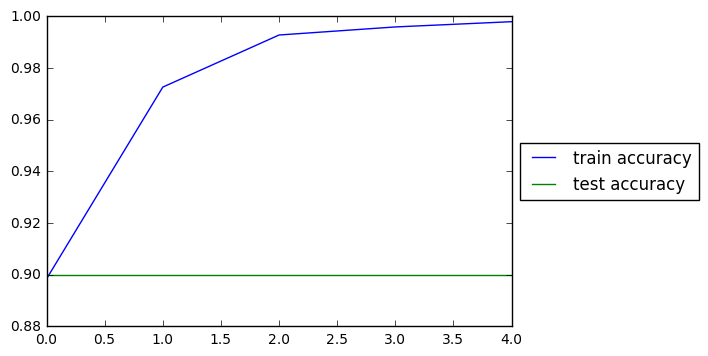

In [12]:
%matplotlib inline

x = range(5)
plt.plot(x, result.history['acc'], label='train accuracy')
plt.plot(x, result.history['val_acc'], label='test accuracy')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [8]:
model_filepath = "./savedModels/ceps_conv_lstm_model.h5"
seq.save(model_filepath)